# Module 3: Linear Models
The goal is developing a machine learning model that, given a user and a product, predicts if the
user would purchase it if they were buying with us at that point in time.

## Load dataset

In [1]:
import pandas as pd
import logging
from typing import Tuple, List, Dict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import numpy as np
import matplotlib
from sklearn.pipeline import make_pipeline
import seaborn as sns
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

We will be using our groceries dataset feature_frame_20210304.csv. This is a well
known dataset by now since we have being working on it over the latest several
weeks. For this reason, this project skips the Exploratory Data Analysis (EDA) phase
as it is should already be available in previous reports.

In [2]:
dataset = pd.read_csv('/home/antonio/zrive-ds/src/module_2/groceries_datasets2/raw/feature_frame.csv')

We should only be focusing on purchases of at least 5 items, since it is a
requirement coming from the sales team.

In [3]:
def filter_orders_with_multiple_purchases(dataset: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    """
    Filters the dataset to keep only the orders that contain at least `min_items` purchased products.

    Parameters:
    - dataset: The original DataFrame with at least 'order_id' and 'outcome' columns.
    - min_items: Minimum number of purchased products required for an order to be considered valid.

    Returns:
    - A filtered DataFrame containing only the valid orders.
    """
    bought_df = dataset[dataset['outcome'] == 1]
    bought_counts = bought_df['order_id'].value_counts()
    valid_orders = bought_counts[bought_counts >= min_items].index
    filtered_df = dataset[dataset['order_id'].isin(valid_orders)]

    return filtered_df


In [4]:

filtered_df = filter_orders_with_multiple_purchases(dataset, min_items=5)

# Convert to datetime
filtered_df = filtered_df.copy()

filtered_df.loc[:, 'order_date'] = pd.to_datetime(filtered_df['order_date'])
filtered_df.loc[:, 'created_at'] = pd.to_datetime(filtered_df['created_at'])

In [5]:
filtered_df['outcome'].value_counts(normalize=True)

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

## Dataset Split

As the time interval we have in the dataset is very small (5 months), it is difficult to make a split that meets all the desirable requirements: large set of train to be able to adjust the weights and sufficiently representative sets of validation and test.
In this case I have chosen to make the following split: 70% train, 20% val and 10% test.

Regarding dataleakage, I have ensured that orders that are in one set, are not repeated in another. I have allowed users to be repeated between sets, because I believe that in a real production situation this could be the case.

In [6]:
# Configure logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def time_aware_order_split_by_percentage(
    df: pd.DataFrame,
    train_frac: float,
    val_frac: float,
    order_date_col: str = 'order_date',
    order_id_col: str = 'order_id',
    user_id_col: str = 'user_id'
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits dataset into train/val/test based on time ranges computed from percentages of order_date.

    Args:
        df: Input DataFrame.
        train_frac: Fraction of time to allocate to training.
        val_frac: Fraction of time to allocate to validation.
                  (test_frac is inferred as 1 - train_frac - val_frac)
        order_date_col: Name of the datetime column.
        order_id_col: Name of the order ID column.
        user_id_col: Name of the user ID column.

    Returns:
        Tuple of (train_df, val_df, test_df)
    """

    assert 0 < train_frac < 1, "train_frac must be between 0 and 1"
    assert 0 < val_frac < 1, "val_frac must be between 0 and 1"
    assert (train_frac + val_frac) < 1, "train + val fractions must be < 1"

    min_date = df[order_date_col].min()
    max_date = df[order_date_col].max()
    total_span = (max_date - min_date).days

    train_cutoff = min_date + pd.Timedelta(days=total_span * train_frac)
    val_cutoff = min_date + pd.Timedelta(days=total_span * (train_frac + val_frac))

    train_df = df[df[order_date_col] <= train_cutoff]
    val_df = df[(df[order_date_col] > train_cutoff) & (df[order_date_col] <= val_cutoff)]
    test_df = df[df[order_date_col] > val_cutoff]

    # Assert no leakage 
    assert train_df[order_date_col].max() <= val_df[order_date_col].min(), "Temporal overlap between train and val"
    assert val_df[order_date_col].max() <= test_df[order_date_col].min(), "Temporal overlap between val and test"

    # Logging 
    def log_split_info(name: str, split_df: pd.DataFrame) -> None:
        if len(split_df) == 0:
            logger.warning(f"{name.upper()} SET is empty.")
            return
        logger.info(f"📂 {name.upper()} SET")
        logger.info(f"  ➤ Rows: {len(split_df)}")
        logger.info(f"  ➤ Unique Orders: {split_df[order_id_col].nunique()}")
        logger.info(f"  ➤ Users: {split_df[user_id_col].nunique()}")
        logger.info(f"  ➤ Date range: {split_df[order_date_col].min()} → {split_df[order_date_col].max()}")

    log_split_info("Train", train_df)
    log_split_info("Validation", val_df)
    log_split_info("Test", test_df)

    return train_df, val_df, test_df




In [7]:
train_df, val_df, test_df = time_aware_order_split_by_percentage(
    filtered_df,
    train_frac=0.7,
    val_frac=0.2,
    order_date_col="order_date",
    order_id_col="order_id",
    user_id_col="user_id"
)

INFO:__main__:📂 TRAIN SET
INFO:__main__:  ➤ Rows: 1053466
INFO:__main__:  ➤ Unique Orders: 1369
INFO:__main__:  ➤ Users: 864
INFO:__main__:  ➤ Date range: 2020-10-05 00:00:00 → 2021-01-17 00:00:00
INFO:__main__:📂 VALIDATION SET
INFO:__main__:  ➤ Rows: 658071
INFO:__main__:  ➤ Unique Orders: 752
INFO:__main__:  ➤ Users: 653
INFO:__main__:  ➤ Date range: 2021-01-18 00:00:00 → 2021-02-16 00:00:00
INFO:__main__:📂 TEST SET
INFO:__main__:  ➤ Rows: 452416
INFO:__main__:  ➤ Unique Orders: 482
INFO:__main__:  ➤ Users: 468
INFO:__main__:  ➤ Date range: 2021-02-17 00:00:00 → 2021-03-03 00:00:00


## Evaluation metrics. 

 As there is a clear tradeoff between how many notifications we send and how much we get to increase sales, we will look at the ROC curve and the PR curve.

In [8]:
def evaluate_plot_metrics(
    model_name: str,
    split: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    metrics_store: Dict[str, Dict[str, float]],
    figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
     
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    m = metrics_store.setdefault(model_name, {})
    m[f"{split}_pr_auc"]  = pr_auc
    m[f"{split}_roc_auc"] = roc_auc
    

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_,precision_, label=f"{model_name} AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title(f'Precision-recall curve')
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model_name} AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f'ROC Curve')
    ax[1].legend()

## Baseline

Before proposing an ML solution, we need to have a baseline that does not use ML in order to assess whether our proposal brings value to the business.

In this case, as we saw in the EDA, the variable ‘global_popularity’ had a good correlation with the target, so we will use it as baseline.

## ML solution

Classification of variable types

In [9]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in dataset.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]
datetime_col = ['order_date']

Split into features and label

In [10]:
def prepare_features_and_target(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.Series]:

    # Check errors 
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in DataFrame: {missing_features}")
    
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Split
    X = df[feature_cols].copy()
    y = df[target_col].copy()

    return X, y

In [11]:
X_train, y_train = prepare_features_and_target(train_df, features_cols, label_col)
X_val, y_val = prepare_features_and_target(val_df, features_cols, label_col)

We start by training only numerical and binary variables. Coding categorical variables is more complex, each step of added complexity must be justified.

In [12]:
train_cols = numerical_cols + binary_cols

### Ridge regression

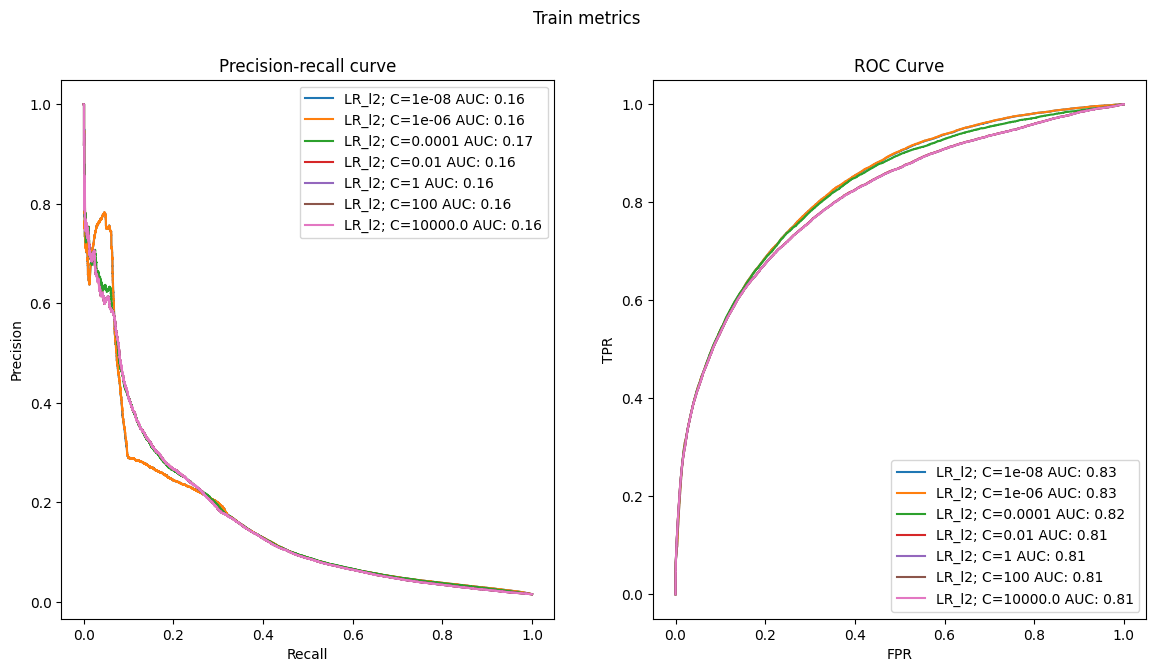

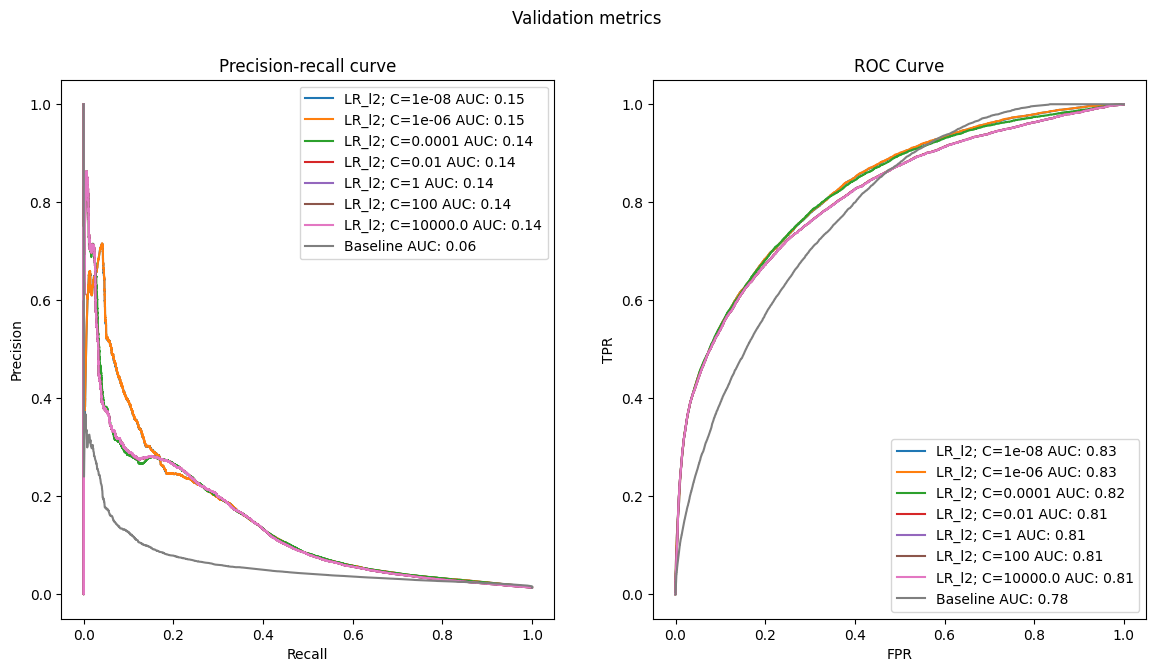

In [13]:
metrics = {}

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]  # 1/alpha
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    evaluate_plot_metrics(
        f"LR_l2; C={c}", split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    evaluate_plot_metrics(
        f"LR_l2; C={c}", split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics, figure=(fig2, ax2)
    )

evaluate_plot_metrics(
    f"Baseline",
    split="val",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    metrics_store=metrics,
    figure=(fig2, ax2),
)


In [14]:
metrics_df = pd.DataFrame.from_dict(metrics, orient="index")

cols = ["train_pr_auc", "train_roc_auc", "val_pr_auc", "val_roc_auc"]
df = metrics_df.reindex(columns=cols).round(3)

print(metrics_df)

                  train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
LR_l2; C=1e-08        0.162396       0.828044    0.154430     0.827316
LR_l2; C=1e-06        0.162489       0.828421    0.154523     0.827717
LR_l2; C=0.0001       0.165815       0.823311    0.144969     0.824481
LR_l2; C=0.01         0.163762       0.809404    0.143411     0.812792
LR_l2; C=1            0.163710       0.809049    0.143377     0.812504
LR_l2; C=100          0.163710       0.809046    0.143376     0.812501
LR_l2; C=10000.0      0.163710       0.809046    0.143376     0.812501
Baseline                   NaN            NaN    0.062088     0.781784


- The results show how the Logistic regression model with L2 penalty clearly beats the baseline.

### Lasso regression

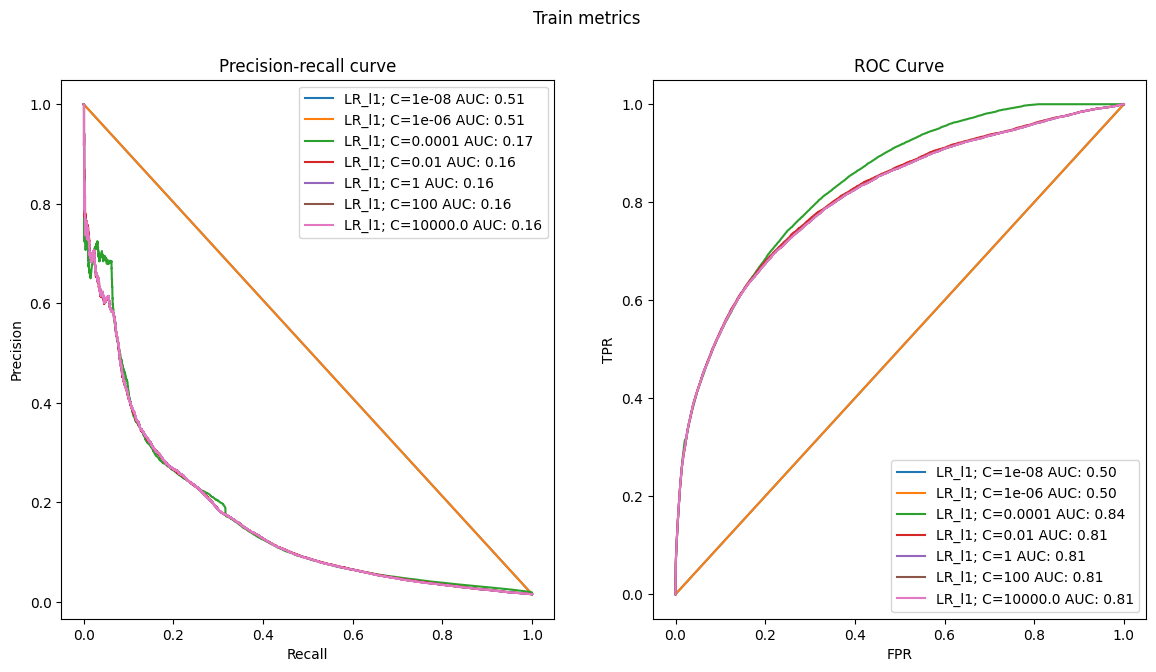

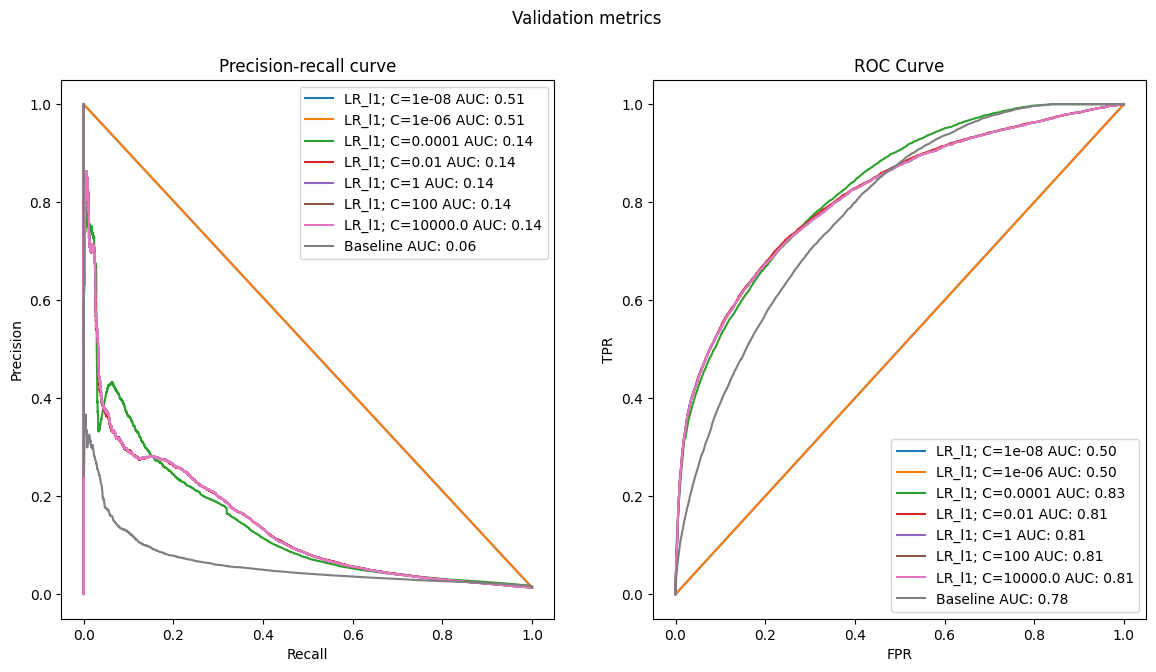

In [15]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]  # 1/alpha
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=c if c else 1.0, solver='saga'),
    )
    lr.fit(X_train[train_cols], y_train)
    
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    evaluate_plot_metrics(
        f"LR_l1; C={c}", split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    evaluate_plot_metrics(
        f"LR_l1; C={c}", split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics, figure=(fig2, ax2)
    )

evaluate_plot_metrics(
    f"Baseline",
    split="val",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    metrics_store=metrics,
    figure=(fig2, ax2),
)

In [16]:
metrics_df = pd.DataFrame.from_dict(metrics, orient="index")

cols = ["train_pr_auc", "train_roc_auc", "val_pr_auc", "val_roc_auc"]
df = metrics_df.reindex(columns=cols).round(3)

print(metrics_df)

                  train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
LR_l2; C=1e-08        0.162396       0.828044    0.154430     0.827316
LR_l2; C=1e-06        0.162489       0.828421    0.154523     0.827717
LR_l2; C=0.0001       0.165815       0.823311    0.144969     0.824481
LR_l2; C=0.01         0.163762       0.809404    0.143411     0.812792
LR_l2; C=1            0.163710       0.809049    0.143377     0.812504
LR_l2; C=100          0.163710       0.809046    0.143376     0.812501
LR_l2; C=10000.0      0.163710       0.809046    0.143376     0.812501
LR_l1; C=1e-08        0.507827       0.500000    0.506766     0.500000
LR_l1; C=1e-06        0.507827       0.500000    0.506766     0.500000
LR_l1; C=0.0001       0.167508       0.835646    0.143161     0.828127
LR_l1; C=0.01         0.163833       0.811523    0.143523     0.814475
LR_l1; C=1            0.163730       0.809362    0.143447     0.812776
LR_l1; C=100          0.163731       0.809337    0.143450     0.812755
LR_l1;

- The results show how the Logistic regression model with L1 penalties are practically the same as those obtained with L2.

### Coefficients weights

In [17]:
lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6),
    )
lr.fit(X_train[train_cols], y_train)
# print(pipe.steps) -> para saber los nombres de los pasos
lr_coeff_l2 = pd.DataFrame({
    "features": train_cols,
    "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]), 
    "regularisation": ["l2"] * len(train_cols)
})
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)


lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", C=1e-4, solver="saga")
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame({
    "features": train_cols,
    "importance": np.abs(lr.named_steps["logisticregression"].coef_[0]),
    "regularisation": ["l1"] * len(train_cols)
})
lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)


lr_coeffs = pd.concat([lr_coeff_l2, lr_coeff_l1])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by=["importance"])


<Axes: xlabel='importance', ylabel='features'>

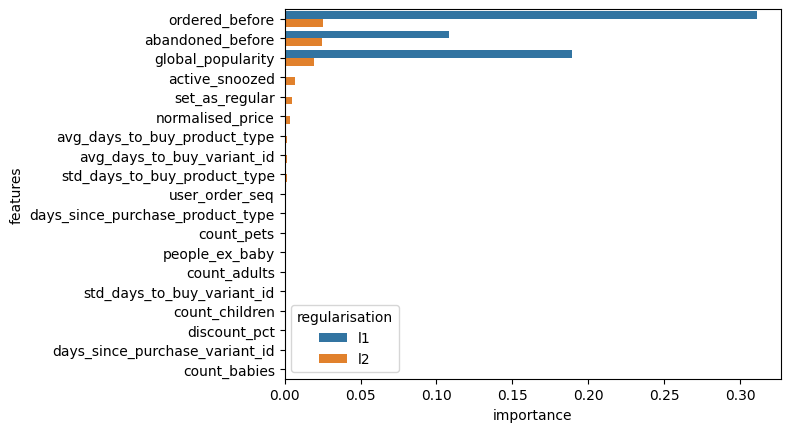

In [18]:
order_columns = lr_coeff_l2.sort_values(by="importance", ascending=False)['features']
sns.barplot(
    data=lr_coeffs,
    x='importance',
    y='features',
    hue='regularisation',
    order=order_columns,
)

- We see how the theory holds, Lasso gives larger values to a few variables, while Ridge has small weights

Let's try training only with the most important variables.

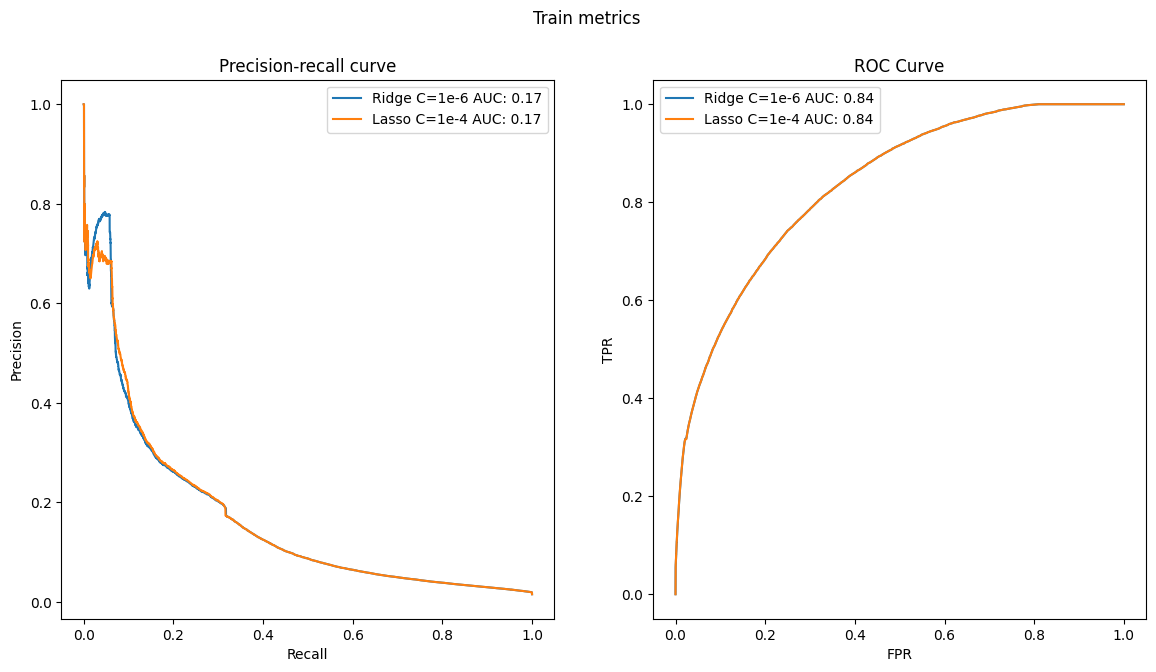

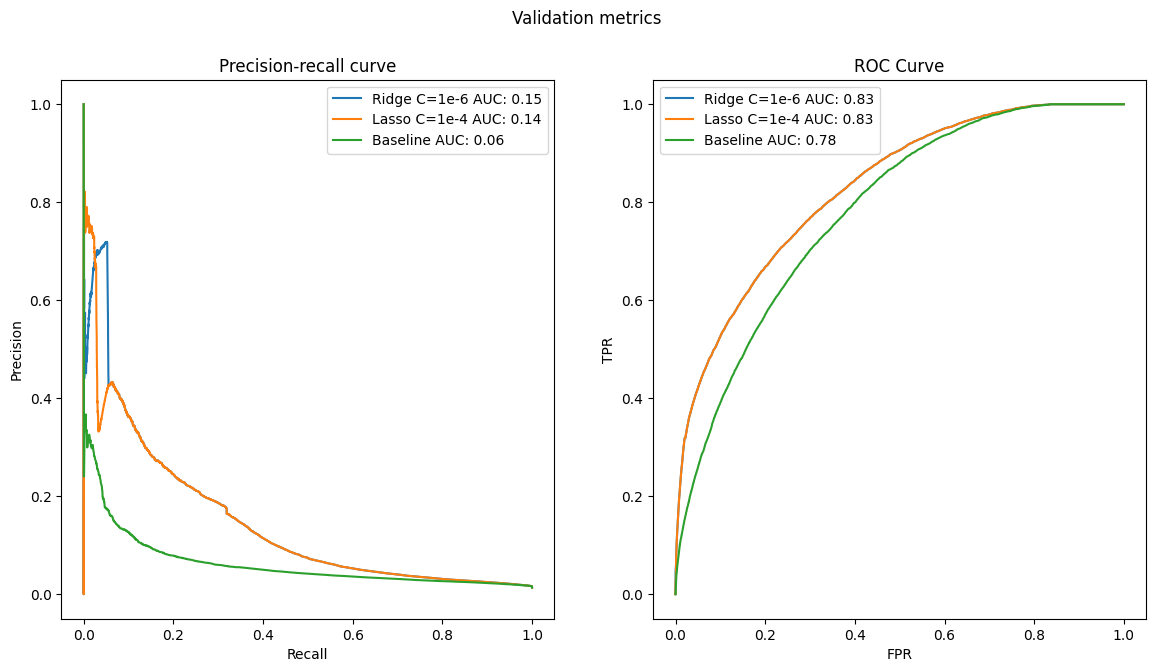

In [19]:
metrics_reduced_cols = {}
reduced_cols = ['ordered_before', 'abandoned_before', 'global_popularity']

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6),
    ),

    make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=1e-4, solver='saga'),
    )
]

names = ['Ridge C=1e-6', 'Lasso C=1e-4']
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]

    evaluate_plot_metrics(
        name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_reduced_cols, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]

    evaluate_plot_metrics(
        name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_reduced_cols, figure=(fig2, ax2)
    )
    
evaluate_plot_metrics(
    f"Baseline",
    split="val",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    metrics_store=metrics_reduced_cols,
    figure=(fig2, ax2),
)

In [20]:
metrics_df = pd.DataFrame.from_dict(metrics_reduced_cols, orient="index")

cols = ["train_pr_auc", "train_roc_auc", "val_pr_auc", "val_roc_auc"]
df = metrics_df.reindex(columns=cols).round(3)

print(metrics_df)

              train_pr_auc  train_roc_auc  val_pr_auc  val_roc_auc
Ridge C=1e-6      0.167811       0.835616    0.147323     0.828144
Lasso C=1e-4      0.167503       0.835646    0.143159     0.828127
Baseline               NaN            NaN    0.062088     0.781784


- we still see that it works the same with fewer variables
- Both L1 and L2 clearly outperform the baseline.
- With a small set of features (3) we obtain promising results.
- It is a good result for an MVP, we improve the baseline with few features and a simple model.

### Categorical Encoding


As we analysed in the EDA, categorical variables have a high cardinality. A possible solution would be to use a frequency encoder. The following is a comparison of different ways of encoding categorical variables.

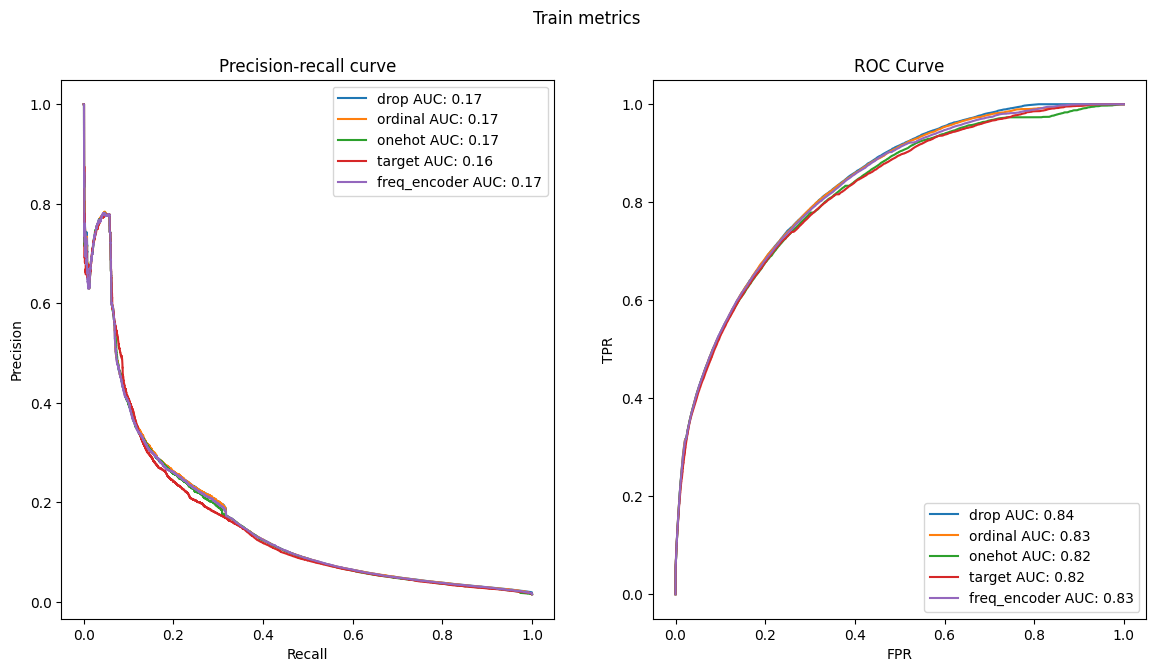

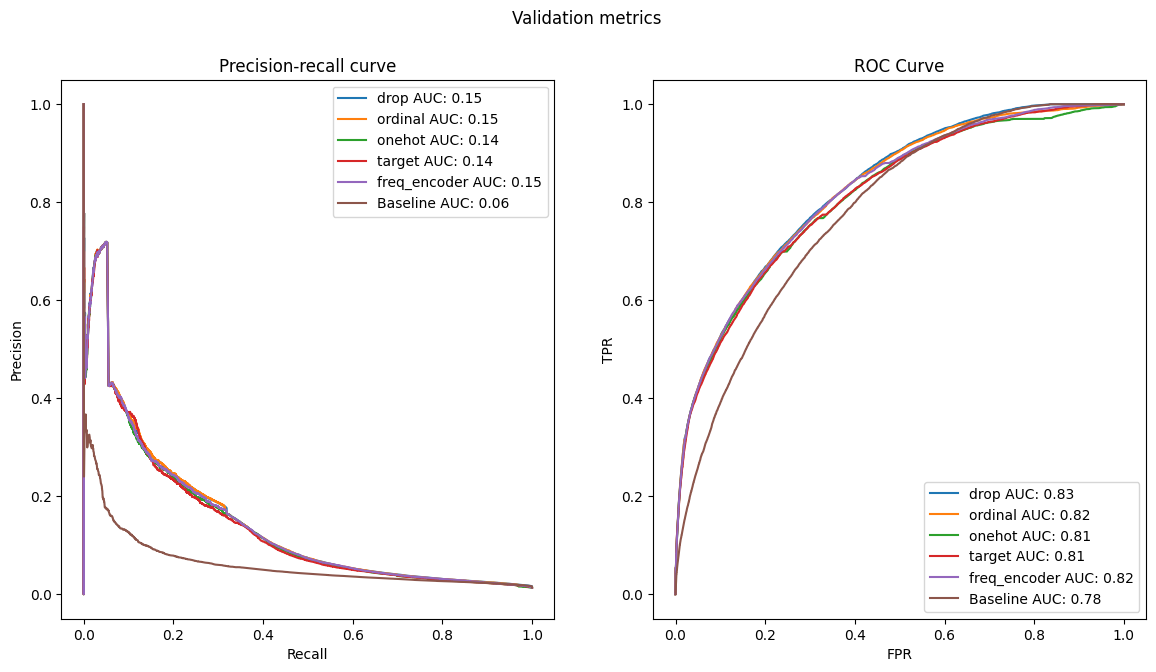

In [21]:
categorical_preprocessors = [
    ("drop",    "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False)),
    ("target",  TargetEncoder(target_type="continuous")),
    ("freq_encoder", ce.CountEncoder(normalize=True)),  
]


fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

extended_cols = reduced_cols + categorical_cols

metrics_categorical = {}
for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", reduced_cols), # no les hace nada
            ('categorical', categorical_preprocessor, categorical_cols),
        ]
    )


    lr = make_pipeline(
        preprocessor,
        StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)
    )

    # fit model and predict
    lr.fit(X_train[extended_cols], y_train)
    
    train_proba = lr.predict_proba(X_train[extended_cols])[:, 1]

    evaluate_plot_metrics(
        name, split="train", y_pred=train_proba, y_test=train_df[label_col], metrics_store=metrics_categorical, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[extended_cols])[:, 1]

    evaluate_plot_metrics(
        name, split="val", y_pred=val_proba, y_test=val_df[label_col], metrics_store=metrics_categorical, figure=(fig2, ax2)
    )

evaluate_plot_metrics(
    f"Baseline",
    split="val",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    metrics_store=metrics_categorical,
    figure=(fig2, ax2),
)

Our analysis does not suggest that adding the categorical variables improves the results.

There are problems that need to be analysed in more detail. For example, the management of new categories that were not in train in freq ecoding. The following were discussed in class:
- Setting it to 0 is wrong, because you will make the system never recommend it. It is like saying that its popularity is 0.
- Another option is to average or better sample around the popularity distribution every day, increasing the variance. You can spend a week with this strategy and then give it the acquired popularity.
- Try to find a similar product that was already sold before. 